# Env

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,accuracy_score,explained_variance_score
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from matplotlib.patches import Wedge, Circle
from matplotlib.colors import TwoSlopeNorm


# Data Cleaning 

In [ ]:
df = pd.read_excel('3d-FCC+0.6NaCl.xlsx',sheet_name='2')
df_feature = pd.read_excel('data_feature_new.xlsx')

df_merged = pd.concat([df, df_feature.iloc[:,8:]], axis=1)
df_merged = df_merged.drop(['Processing', 'Phases present', 'FCC', 'Test environment',
       'Concentration in M', 'Electrolyte'],axis=1)

df_merged = df_merged.drop(['Ipass','Ecorr','△E'],axis=1)
df_merged.shape

target_substring = "Mis"
feature_Mis = [col for col in df_merged.columns if target_substring.lower() in col.lower()]
df_merged = df_merged.drop(feature_Mis,axis=1)
df_merged.shape
df = df_merged.drop('Icorr',axis=1)
df = df.drop('Alloy name',axis=1)

In [215]:
def filter_outliers_zscore(df, threshold=3, max_outlier_cols=0):
    df_clean = df.copy()
    num_cols = df_clean.select_dtypes(include=[np.number]).columns
    vals = df_clean[num_cols]
    z = (vals - vals.mean()) / vals.std(ddof=0)
    z = z.replace([np.inf, -np.inf], np.nan).fillna(0.0).abs()
    outlier_counts = (z >= threshold).sum(axis=1)
    keep_mask = outlier_counts <= max_outlier_cols
    return df_clean.loc[keep_mask].copy()

df_clean = filter_outliers_zscore(df, threshold=3.5, max_outlier_cols=0)
df = df_clean


In [216]:
df.shape

(85, 40)

# PCC

In [ ]:
X_PCC = X[[col for col in X.columns if col not in base_features]]
correlation_matrix = X_PCC.corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
plt.figure(figsize=(30, 20))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},  # 字体大小
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True
)
plt.title("Upper Triangle Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def filter_features_by_correlation(corr_matrix, threshold):
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                to_drop.add(colname)
    
    return [col for col in corr_matrix.columns if col not in to_drop]
filter_feature_PCC = filter_features_by_correlation(correlation_matrix,0.9)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


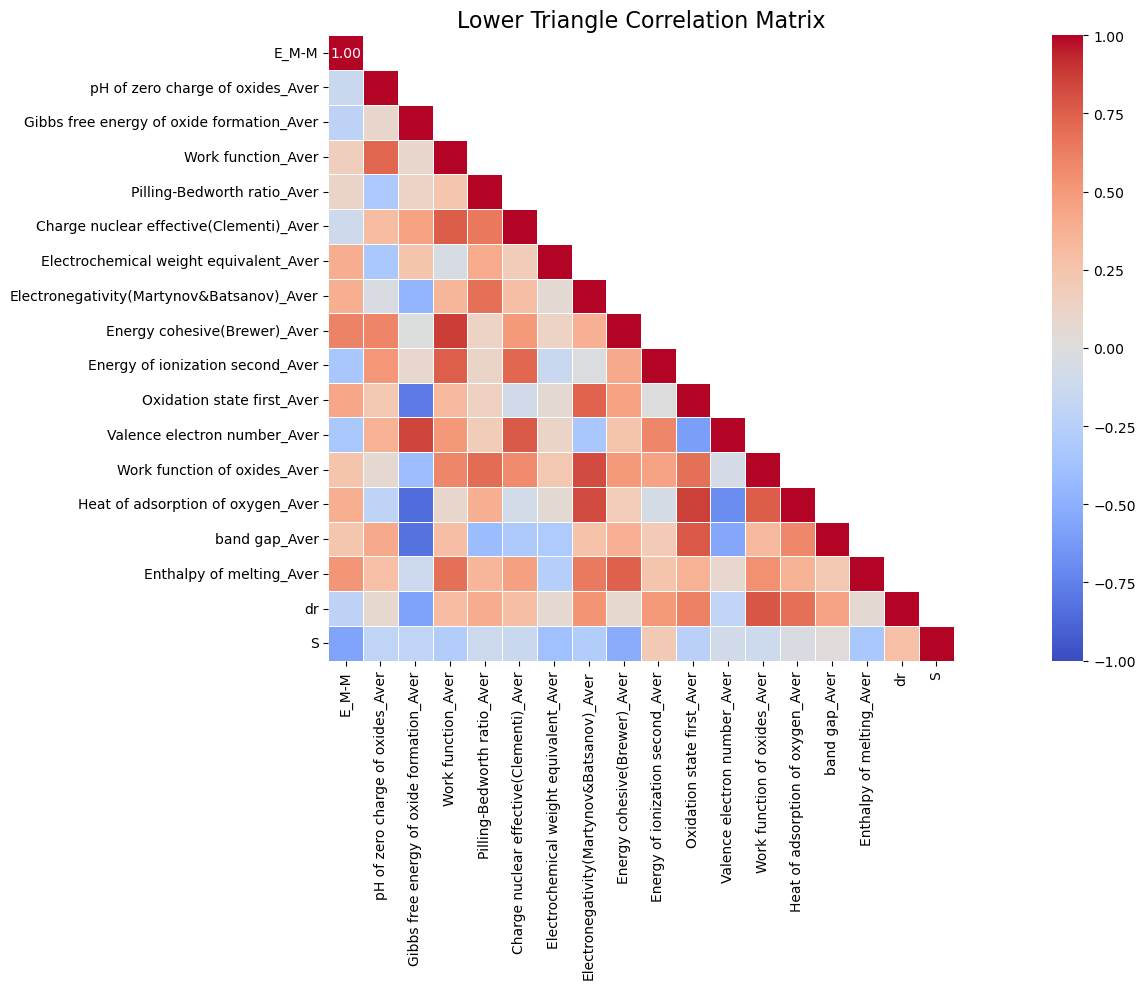

In [220]:
X1 = X[filter_feature_PCC]
correlation_matrix_1 = X1.corr(method='pearson')
correlation_matrix_1 = correlation_matrix_1.astype(float)
mask = np.triu(np.ones_like(correlation_matrix_1, dtype=bool), k=1)
plt.figure(figsize=(20, 10))
sns.heatmap(
    correlation_matrix_1,
    mask=mask,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True
)
plt.title("Lower Triangle Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

In [221]:
X1.head()

,E_M-M,pH of zero charge of oxides_Aver,Gibbs free energy of oxide formation_Aver,Work function_Aver,Pilling-Bedworth ratio_Aver,Charge nuclear effective(Clementi)_Aver,Electrochemical weight equivalent_Aver,Electronegativity(Martynov&Batsanov)_Aver,Energy cohesive(Brewer)_Aver,Energy of ionization second_Aver,Oxidation state first_Aver,Valence electron number_Aver,Work function of oxides_Aver,Heat of adsorption of oxygen_Aver,band gap_Aver,Enthalpy of melting_Aver,dr,S
0,68.132667,8.634000,-8.320000,4.660000,2.002583,5.558000,0.454814,1.654000,3.904000,1685.400000,1.800000,9.000000,4.995400,474.136000,2.396000,14.740000,0.031774,13.380867
1,73.457292,8.875000,31.987500,4.800000,1.937010,5.640000,0.532942,1.557500,4.150000,1729.500000,1.750000,9.500000,4.964250,435.920000,2.500000,15.075000,0.011379,11.525651
2,70.520799,8.394545,-38.626364,4.645455,2.005315,5.519091,0.421634,1.685455,3.921818,1676.909091,1.818182,8.727273,5.023091,498.032727,2.496364,15.309091,0.030834,14.697169
3,73.457292,8.875000,31.987500,4.800000,1.937010,5.640000,0.532942,1.557500,4.150000,1729.500000,1.750000,9.500000,4.964250,435.920000,2.500000,15.075000,0.011379,11.525651
4,76.175666,8.534414,-124.008204,4.741326,2.072305,5.505798,0.407272,1.876238,4.103688,1657.094493,2.078072,8.042286,5.253451,586.578529,2.979563,16.557545,0.045072,14.225104


In [222]:
filter_feature_PCC = base_features + filter_feature_PCC
X1 = X[filter_feature_PCC]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X1)
X_scaled = pd.DataFrame(X_scaled, columns=X1.columns)
print('X_scaled shape:', X_scaled.shape)
print('Y shape:', Y.shape)


X_scaled shape: (83, 25)
Y shape: (83,)


In [223]:
tmp = pd.DataFrame(np.concatenate([X1, Y.to_numpy().reshape(-1,1)], axis=1))
tmp.columns = X1.columns.tolist() + ['Epit']

In [225]:
tmp.describe()

,Fe,Cr,Ni,Mn,Al,Cu,Co,E_M-M,pH of zero charge of oxides_Aver,Gibbs free energy of oxide formation_Aver,...,Energy of ionization second_Aver,Oxidation state first_Aver,Valence electron number_Aver,Work function of oxides_Aver,Heat of adsorption of oxygen_Aver,band gap_Aver,Enthalpy of melting_Aver,dr,S,Epit
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.239551,0.207775,0.227775,0.045204,0.024498,0.044952,0.212944,80.979292,8.426775,-91.476936,...,1655.254571,1.984944,8.241702,5.123041,547.635500,2.966998,16.505142,0.023135,12.443882,174.125301
std,0.072769,0.067522,0.048042,0.080091,0.047947,0.075232,0.069119,3.836747,0.377207,47.583005,...,43.838339,0.107659,0.438001,0.129396,39.427638,0.320838,0.731285,0.024569,1.187749,275.003295
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,68.132667,7.454000,-238.730000,...,1595.200000,1.750000,7.200000,4.964250,435.920000,2.396000,14.740000,0.001685,9.133863,-585.000000
25%,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.200000,78.775062,8.314000,-108.984000,...,1638.000000,1.888889,7.943750,5.071889,519.236190,2.756000,16.040000,0.003153,11.525651,27.500000
50%,0.232558,0.222222,0.222222,0.000000,0.000000,0.000000,0.222222,81.701646,8.475000,-85.251538,...,1650.517300,2.000000,8.250000,5.122000,546.920000,2.950000,16.616279,0.022981,12.647715,90.000000
75%,0.250000,0.250000,0.250000,0.052551,0.027195,0.111111,0.250000,84.107983,8.533333,-59.615556,...,1673.555555,2.012545,8.555556,5.141860,568.336000,3.181818,17.073958,0.034548,13.249722,335.000000
max,0.400000,0.333333,0.400000,0.202801,0.200000,0.250000,0.333333,88.286000,9.300000,31.987500,...,1937.133333,2.400000,9.500000,6.190667,715.066667,3.960000,20.013333,0.184748,14.896688,860.000000


In [226]:
X_scaled.shape

(83, 25)

# Model

## XGBoost

In [ ]:
base_features = ['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co']
all_features = list(X_scaled.columns)
candidate_features = list(set(all_features) - set(base_features))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_params = dict(n_estimators=100, learning_rate=0.01, random_state=42)

def cv_rmse_mean_std(X_df, y, feats):
    model = XGBRegressor(**xgb_params)
    scores = cross_val_score(
        model, X_df[feats], y,
        cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1
    )
    rmse = -scores
    return rmse.mean(), rmse.std()

selected = list(base_features)
remaining = list(candidate_features)
history = []

base_mean, base_std = cv_rmse_mean_std(X_scaled, Y, selected)

step = 0
while remaining:
    step += 1
    scores = {}
    for feat in remaining:
        current_features = selected + [feat]
        mean_rmse, std_rmse = cv_rmse_mean_std(X_scaled, Y, current_features)
        scores[feat] = (mean_rmse, std_rmse)

    best_feature = min(scores, key=lambda f: scores[f][0])
    best_mean, best_std = scores[best_feature]

    history.append((list(selected) + [best_feature], best_mean, best_std))
    selected.append(best_feature)
    remaining.remove(best_feature)


print("\nForward Selection History:")
print(f"Step 00: BASE-7       | Total Features: {len(base_features):<2} | RMSE: {base_mean:.4f} ± {base_std:.4f}")
for i, (feats, mean_rmse, std_rmse) in enumerate(history, 1):
    print(f"Step {i:02d}: {feats[-1]:<12} | Total Features: {len(feats):<2} | RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")



Forward Selection History:
Step 00: BASE-7       | Total Features: 7  | RMSE: 222.5606 ± 35.8054
Step 01: Oxidation state first_Aver | Total Features: 8  | RMSE: 219.9431 ± 35.7222
Step 02: Energy cohesive(Brewer)_Aver | Total Features: 9  | RMSE: 217.5966 ± 33.5456
Step 03: band gap_Aver | Total Features: 10 | RMSE: 216.7702 ± 38.0117
Step 04: Charge nuclear effective(Clementi)_Aver | Total Features: 11 | RMSE: 216.3722 ± 38.1381
Step 05: Enthalpy of melting_Aver | Total Features: 12 | RMSE: 216.0273 ± 37.2605
Step 06: Work function_Aver | Total Features: 13 | RMSE: 216.0273 ± 37.2605
Step 07: S            | Total Features: 14 | RMSE: 216.0273 ± 37.2605
Step 08: dr           | Total Features: 15 | RMSE: 216.0856 ± 37.2858
Step 09: Work function of oxides_Aver | Total Features: 16 | RMSE: 216.1766 ± 37.2811
Step 10: Valence electron number_Aver | Total Features: 17 | RMSE: 216.2753 ± 37.3070
Step 11: Energy of ionization second_Aver | Total Features: 18 | RMSE: 216.8102 ± 36.5575
Step

In [232]:
rows = [{
        "Step": 0,
        "Added Feature": "BASE-7",
        "Total Features": len(base_features),
        "RMSE Mean": base_mean,
        "RMSE Std": base_std
    }]
for i, (feats, mean_rmse, std_rmse) in enumerate(history, 1):
        rows.append({
            "Step": i,
            "Added Feature": feats[-1],
            "Total Features": len(feats),
            "RMSE Mean": mean_rmse,
            "RMSE Std": std_rmse
        })
tmp1 = pd.DataFrame(rows)
tmp1
with pd.ExcelWriter("correlation_matrix_1.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    tmp1.to_excel(writer, sheet_name="XGBoost特征正向筛选",index = False)

In [ ]:
k = 5  # 5-fold
means = np.array([m for _, m, _ in history], dtype=float)
stds  = np.array([s for _, _, s in history], dtype=float)
ses   = stds / np.sqrt(k)

best_idx = int(np.argmin(means))
best_mean, best_se = means[best_idx], ses[best_idx]

idx_1se = int(np.where(means <= best_mean + best_se)[0][0])
selected_1se = history[idx_1se][0]
idx_min = best_idx
selected_min = history[idx_min][0]

print("1-SE 规则选择的步 =", idx_1se+1, "\n特征数 =", len(selected_1se))
print(selected_1se)

print("\n最小均值规则选择的步 =", idx_min+1, "\n特征数 =", len(selected_min))
print(selected_min)

low, high = sorted([idx_1se, idx_min])
idx_mid = (low + high) // 2          # 取中点的下取整
selected_mid = history[idx_mid][0]
print("\nmidpoint 规则选择的步 =", idx_mid+1, 
      "\n特征数 =", len(selected_mid))
print(selected_mid)

1-SE 规则选择的步 = 1 
特征数 = 8
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'Oxidation state first_Aver']

最小均值规则选择的步 = 5 
特征数 = 12
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'Oxidation state first_Aver', 'Energy cohesive(Brewer)_Aver', 'band gap_Aver', 'Charge nuclear effective(Clementi)_Aver', 'Enthalpy of melting_Aver']

midpoint 规则选择的步 = 3 
特征数 = 10
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'Oxidation state first_Aver', 'Energy cohesive(Brewer)_Aver', 'band gap_Aver']


## RF

In [ ]:
base_features = ['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co']
all_features = list(X_scaled.columns)
candidate_features = list(set(all_features) - set(base_features))

selected = list(base_features)
remaining = list(candidate_features)
history = []   # [(features_list, mean_rmse, std_rmse), ...]

rf_params = dict(
    n_estimators=100,
    max_depth=4,
    min_samples_leaf=3,
    min_samples_split=6,
    random_state=42,
    n_jobs=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse_mean_std(X_df, y, feats):
    model = RandomForestRegressor(**rf_params)
    scores = cross_val_score(
        model, X_df[feats], y,
        cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1
    )
    rmse = -scores
    return rmse.mean(), rmse.std()

base_mean, base_std = cv_rmse_mean_std(X_scaled, Y, selected)
step = 0
while remaining:
    step += 1
    scores = {}
    for feat in remaining:
        feats_now = selected + [feat]
        mean_rmse, std_rmse = cv_rmse_mean_std(X_scaled, Y, feats_now)
        scores[feat] = (mean_rmse, std_rmse)

    best_feature = min(scores, key=lambda f: scores[f][0])
    best_mean, best_std = scores[best_feature]

    history.append((list(selected) + [best_feature], best_mean, best_std))
    selected.append(best_feature)
    remaining.remove(best_feature)

print("\nForward Selection History:")
print(f"Step 00: BASE-7       | Total Features: {len(base_features):<2} | RMSE: {base_mean:.4f} ± {base_std:.4f}")
for i, (feats, mean_rmse, std_rmse) in enumerate(history, 1):
    print(f"Step {i:02d}: {feats[-1]:<20} | Total Features: {len(feats):<2} "
          f"| RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")



Forward Selection History:
Step 00: BASE-7       | Total Features: 7  | RMSE: 230.7903 ± 25.8113
Step 01: band gap_Aver        | Total Features: 8  | RMSE: 220.0943 ± 24.9036
Step 02: Enthalpy of melting_Aver | Total Features: 9  | RMSE: 217.6200 ± 27.0806
Step 03: Charge nuclear effective(Clementi)_Aver | Total Features: 10 | RMSE: 217.2235 ± 26.0874
Step 04: Energy cohesive(Brewer)_Aver | Total Features: 11 | RMSE: 216.6452 ± 25.4699
Step 05: E_M-M                | Total Features: 12 | RMSE: 216.7085 ± 24.5727
Step 06: Work function of oxides_Aver | Total Features: 13 | RMSE: 215.3142 ± 24.5895
Step 07: Gibbs free energy of oxide formation_Aver | Total Features: 14 | RMSE: 215.8172 ± 25.7298
Step 08: dr                   | Total Features: 15 | RMSE: 215.6787 ± 25.0861
Step 09: Work function_Aver   | Total Features: 16 | RMSE: 216.8049 ± 24.9411
Step 10: Valence electron number_Aver | Total Features: 17 | RMSE: 216.0437 ± 25.9753
Step 11: S                    | Total Features: 18 | R

In [235]:
rows = [{
        "Step": 0,
        "Added Feature": "BASE-7",
        "Total Features": len(base_features),
        "RMSE Mean": base_mean,
        "RMSE Std": base_std
    }]
for i, (feats, mean_rmse, std_rmse) in enumerate(history, 1):
        rows.append({
            "Step": i,
            "Added Feature": feats[-1],
            "Total Features": len(feats),
            "RMSE Mean": mean_rmse,
            "RMSE Std": std_rmse
        })
tmp2 = pd.DataFrame(rows)
with pd.ExcelWriter("correlation_matrix_1.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    tmp2.to_excel(writer, sheet_name="RF特征正向筛选",index = False)

In [ ]:
k = 5  # 5-fold
means = np.array([m for _, m, _ in history], dtype=float)
stds  = np.array([s for _, _, s in history], dtype=float)
ses   = stds / np.sqrt(k)

best_idx = int(np.argmin(means))
best_mean, best_se = means[best_idx], ses[best_idx]

idx_1se = int(np.where(means <= best_mean + best_se)[0][0])
selected_1se = history[idx_1se][0]
idx_min = best_idx
selected_min = history[idx_min][0]

print("1-SE 规则选择的步 =", idx_1se+1, "\n特征数 =", len(selected_1se))
print(selected_1se)

print("\n最小均值规则选择的步 =", idx_min+1, "\n特征数 =", len(selected_min))
print(selected_min)

low, high = sorted([idx_1se, idx_min])
idx_mid = (low + high) // 2          
selected_mid = history[idx_mid][0]

print("\nmidpoint 规则选择的步 =", idx_mid+1, 
      "\n特征数 =", len(selected_mid))
print(selected_mid)

1-SE 规则选择的步 = 1 
特征数 = 8
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'band gap_Aver']

最小均值规则选择的步 = 11 
特征数 = 18
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'band gap_Aver', 'Enthalpy of melting_Aver', 'Charge nuclear effective(Clementi)_Aver', 'Energy cohesive(Brewer)_Aver', 'E_M-M', 'Work function of oxides_Aver', 'Gibbs free energy of oxide formation_Aver', 'dr', 'Work function_Aver', 'Valence electron number_Aver', 'S']

midpoint 规则选择的步 = 6 
特征数 = 13
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'band gap_Aver', 'Enthalpy of melting_Aver', 'Charge nuclear effective(Clementi)_Aver', 'Energy cohesive(Brewer)_Aver', 'E_M-M', 'Work function of oxides_Aver']


## SVR

In [ ]:
base_features = ['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co']
all_features = list(X_scaled.columns)
candidate_features = list(set(all_features) - set(base_features))

selected = list(base_features)
remaining = list(candidate_features)
history = [] 

kf = KFold(n_splits=5, shuffle=True, random_state=42)
svr_params = dict(kernel='linear', C=1.0, epsilon=0.1)

def cv_rmse_mean_std(X_df, y, feats):
    model = SVR(**svr_params)
    scores = cross_val_score(
        model, X_df[feats], np.ravel(y),
        cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1
    )
    rmse = -scores  
    return rmse.mean(), rmse.std()

base_mean, base_std = cv_rmse_mean_std(X_scaled, Y, selected)
step = 0
while remaining:
    step += 1
    scores = {}
    for feat in remaining:
        feats_now = selected + [feat]
        mean_rmse, std_rmse = cv_rmse_mean_std(X_scaled, Y, feats_now)
        scores[feat] = (mean_rmse, std_rmse)

    best_feature = min(scores, key=lambda f: scores[f][0])
    best_mean, best_std = scores[best_feature]

    history.append((list(selected) + [best_feature], best_mean, best_std))
    selected.append(best_feature)
    remaining.remove(best_feature)

    # print(f"Step {step:02d} | Added: {best_feature:<20} "
    #       f"| RMSE (5-fold): {best_mean:.4f} ± {best_std:.4f} "
    #       f"| #Features: {len(selected)}")

print("\nForward Selection History (SVR, 5-fold CV):")
print(f"Step 00: BASE-7       | Total Features: {len(base_features):<2} | RMSE: {base_mean:.4f} ± {base_std:.4f}")
for i, (feats, mean_rmse, std_rmse) in enumerate(history, 1):
    print(f"Step {i:02d}: {feats[-1]:<20} | Total Features: {len(feats):<2} "
          f"| RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")


Forward Selection History (SVR, 5-fold CV):
Step 00: BASE-7       | Total Features: 7  | RMSE: 272.4359 ± 45.6764
Step 01: E_M-M                | Total Features: 8  | RMSE: 270.5458 ± 45.6071
Step 02: band gap_Aver        | Total Features: 9  | RMSE: 269.0772 ± 45.5535
Step 03: Enthalpy of melting_Aver | Total Features: 10 | RMSE: 268.3904 ± 45.5626
Step 04: Gibbs free energy of oxide formation_Aver | Total Features: 11 | RMSE: 268.0629 ± 45.4707
Step 05: Oxidation state first_Aver | Total Features: 12 | RMSE: 267.7306 ± 45.4633
Step 06: Energy cohesive(Brewer)_Aver | Total Features: 13 | RMSE: 267.2247 ± 45.3433
Step 07: S                    | Total Features: 14 | RMSE: 266.6430 ± 45.4935
Step 08: pH of zero charge of oxides_Aver | Total Features: 15 | RMSE: 266.1207 ± 45.4999
Step 09: Heat of adsorption of oxygen_Aver | Total Features: 16 | RMSE: 265.8031 ± 45.4917
Step 10: Work function_Aver   | Total Features: 17 | RMSE: 265.6304 ± 45.4776
Step 11: Electronegativity(Martynov&Batsa

In [237]:
rows = [{
        "Step": 0,
        "Added Feature": "BASE-7",
        "Total Features": len(base_features),
        "RMSE Mean": base_mean,
        "RMSE Std": base_std
    }]
for i, (feats, mean_rmse, std_rmse) in enumerate(history, 1):
        rows.append({
            "Step": i,
            "Added Feature": feats[-1],
            "Total Features": len(feats),
            "RMSE Mean": mean_rmse,
            "RMSE Std": std_rmse
        })
tmp3 = pd.DataFrame(rows)
with pd.ExcelWriter("correlation_matrix_1.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    tmp3.to_excel(writer, sheet_name="SVR特征正向筛选",index = False)

In [ ]:
k = 5  # 5-fold
means = np.array([m for _, m, _ in history], dtype=float)
stds  = np.array([s for _, _, s in history], dtype=float)
ses   = stds / np.sqrt(k)

best_idx = int(np.argmin(means))
best_mean, best_se = means[best_idx], ses[best_idx]

idx_1se = int(np.where(means <= best_mean + best_se)[0][0])
selected_1se = history[idx_1se][0]
idx_min = best_idx
selected_min = history[idx_min][0]

print("1-SE 规则选择的步 =", idx_1se+1, "\n特征数 =", len(selected_1se))
print(selected_1se)

print("\n最小均值规则选择的步 =", idx_min+1, "\n特征数 =", len(selected_min))
print(selected_min)

low, high = sorted([idx_1se, idx_min])
idx_mid = (low + high) // 2          # 取中点的下取整
selected_mid = history[idx_mid][0]

print("\nmidpoint 规则选择的步 =", idx_mid+1, 
      "\n特征数 =", len(selected_mid))
print(selected_mid)


1-SE 规则选择的步 = 1 
特征数 = 8
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'E_M-M']

最小均值规则选择的步 = 14 
特征数 = 21
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'E_M-M', 'band gap_Aver', 'Enthalpy of melting_Aver', 'Gibbs free energy of oxide formation_Aver', 'Oxidation state first_Aver', 'Energy cohesive(Brewer)_Aver', 'S', 'pH of zero charge of oxides_Aver', 'Heat of adsorption of oxygen_Aver', 'Work function_Aver', 'Electronegativity(Martynov&Batsanov)_Aver', 'Electrochemical weight equivalent_Aver', 'Valence electron number_Aver', 'Work function of oxides_Aver']

midpoint 规则选择的步 = 7 
特征数 = 14
['Fe', 'Cr', 'Ni', 'Mn', 'Al', 'Cu', 'Co', 'E_M-M', 'band gap_Aver', 'Enthalpy of melting_Aver', 'Gibbs free energy of oxide formation_Aver', 'Oxidation state first_Aver', 'Energy cohesive(Brewer)_Aver', 'S']


## RobustNN

In [ ]:
class RobustNN(nn.Module):
    def __init__(self, input_dim):
        super(RobustNN, self).__init__()
        self.feature_weights = nn.Parameter(torch.ones(input_dim))  
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x * self.feature_weights
        return self.net(x)
    
def loss_fn_with_l1(output, target, model, l1_lambda=0.01):
    mse_loss = nn.MSELoss()(output, target)
    l1_penalty = l1_lambda * torch.norm(model.feature_weights, p=1)
    return mse_loss + l1_penalty

def train_model(model, train_loader, val_loader, num_epochs=200, patience=20, l1_lambda=0.01, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            preds = model(batch_X).squeeze()
            loss = loss_fn_with_l1(preds, batch_y, model, l1_lambda)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_preds = model(val_X).squeeze()
                val_loss = loss_fn_with_l1(val_preds, val_y, model, l1_lambda)
                val_losses.append(val_loss.item())

        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)

        # print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # print("Early stopping triggered!")
                break

    model.load_state_dict(best_model_state)

    # plt.plot(train_loss_history, label='Train Loss')
    # plt.plot(val_loss_history, label='Val Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title("Training and Validation Loss")
    # plt.grid(True)
    # plt.show()

    return model

def evaluate_model(model, test_loader, y_scaler):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch).squeeze()
            predictions.append(output.cpu().numpy())
            targets.append(y_batch.cpu().numpy())

    preds = np.concatenate(predictions)
    trues = np.concatenate(targets)

    preds_real = y_scaler.inverse_transform(preds.reshape(-1, 1)).ravel()
    trues_real = y_scaler.inverse_transform(trues.reshape(-1, 1)).ravel()

    mae = mean_absolute_error(trues_real, preds_real)
    mse = mean_squared_error(trues_real, preds_real)
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_real, preds_real)


    # print("\n=== 测试集评估结果 ===")
    # # print(f"MAE: {mae:.4f}")
    # # print(f"MSE: {mse:.4f}")
    # print(f"RMSE: {rmse:.4f}")
    # print(f"R2: {r2:.4f}")

    return preds_real, trues_real

In [239]:
y_scaler = MinMaxScaler(feature_range=(-1, 1))
Y_scaled = y_scaler.fit_transform(Y.to_numpy().reshape(-1, 1)).flatten()

In [240]:
X_scaled.shape, Y_scaled.shape

((83, 25), (83,))

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

if hasattr(X_scaled, "columns"):
    feature_names = list(X_scaled.columns)
    X_np = X_scaled.to_numpy(dtype=np.float32)
else:
    X_np = np.asarray(X_scaled, dtype=np.float32)
    feature_names = [f"f{i}" for i in range(X_np.shape[1])]
y_np = np.asarray(Y_scaled, dtype=np.float32).reshape(-1)

base_feature_names = ['Fe','Cr','Ni','Mn','Al','Cu','Co']
missing = [f for f in base_feature_names if f not in feature_names]
base_idx = [feature_names.index(f) for f in base_feature_names]

n_samples, n_features = X_np.shape
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

num_epochs = 100
patience = 5
l1_lambda = 0.01
lr = 1e-3
batch_size = 64

selected_idx = base_idx.copy()
remaining_idx = [i for i in range(n_features) if i not in selected_idx]

rows = []

X_sub = X_np[:, selected_idx]
rmse_list = []
for fold_id, (tr_idx, va_idx) in enumerate(kf.split(X_sub)):
    X_tr, X_va = X_sub[tr_idx], X_sub[va_idx]
    y_tr, y_va = y_np[tr_idx], y_np[va_idx]

    torch.manual_seed(1234 + fold_id)

    train_ds = TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                             torch.tensor(y_tr, dtype=torch.float32))
    val_ds   = TensorDataset(torch.tensor(X_va, dtype=torch.float32),
                             torch.tensor(y_va, dtype=torch.float32))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    model_cv = RobustNN(input_dim=X_tr.shape[1])
    model_cv = train_model(model_cv, train_loader, val_loader,
                           num_epochs=num_epochs, patience=patience,
                           l1_lambda=l1_lambda, lr=lr)

    model_cv.eval()
    preds_scaled, trues_scaled = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model_cv(xb).squeeze()
            preds_scaled.append(out.cpu().numpy())
            trues_scaled.append(yb.cpu().numpy())
    y_pred_scaled = np.concatenate(preds_scaled)
    y_true_scaled = np.concatenate(trues_scaled)

    y_pred_real = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true_real = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()
    rmse_list.append(np.sqrt(mean_squared_error(y_true_real, y_pred_real)))

rows.append({
    "Step": 0,
    "Added Feature": "BASE",
    "Total Features": len(selected_idx),
    "RMSE Mean": float(np.mean(rmse_list)),
    "RMSE Std":  float(np.std(rmse_list, ddof=1)) if len(rmse_list) > 1 else 0.0,
})

step = 0
while len(remaining_idx) > 0:
    step += 1
    best_candidate = None
    best_rmse_mean = np.inf
    best_rmse_std  = None
    best_added_name = None

    for j in remaining_idx:
        curr_idx = selected_idx + [j]
        X_sub = X_np[:, curr_idx]
        rmse_list = []
        for fold_id, (tr_idx, va_idx) in enumerate(kf.split(X_sub)):
            X_tr, X_va = X_sub[tr_idx], X_sub[va_idx]
            y_tr, y_va = y_np[tr_idx], y_np[va_idx]

            torch.manual_seed(5678 + fold_id + j)
            train_ds = TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                                     torch.tensor(y_tr, dtype=torch.float32))
            val_ds   = TensorDataset(torch.tensor(X_va, dtype=torch.float32),
                                     torch.tensor(y_va, dtype=torch.float32))
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
            model_cv = RobustNN(input_dim=X_tr.shape[1])
            model_cv = train_model(model_cv, train_loader, val_loader,
                                   num_epochs=num_epochs, patience=patience,
                                   l1_lambda=l1_lambda, lr=lr)

            model_cv.eval()
            preds_scaled, trues_scaled = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    out = model_cv(xb).squeeze()
                    preds_scaled.append(out.cpu().numpy())
                    trues_scaled.append(yb.cpu().numpy())
            y_pred_scaled = np.concatenate(preds_scaled)
            y_true_scaled = np.concatenate(trues_scaled)

            # 关键：反缩放回真实量纲
            y_pred_real = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
            y_true_real = y_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()

            rmse_list.append(np.sqrt(mean_squared_error(y_true_real, y_pred_real)))

        rmse_mean = float(np.mean(rmse_list))
        rmse_std  = float(np.std(rmse_list, ddof=1)) if len(rmse_list) > 1 else 0.0

        if rmse_mean < best_rmse_mean:
            best_rmse_mean = rmse_mean
            best_rmse_std  = rmse_std
            best_candidate = j
            best_added_name = feature_names[j]

    selected_idx.append(best_candidate)
    remaining_idx.remove(best_candidate)

    rows.append({
        "Step": step,
        "Added Feature": best_added_name,
        "Total Features": len(selected_idx),
        "RMSE Mean": best_rmse_mean,
        "RMSE Std":  best_rmse_std
    })

df_sfs_rmse = pd.DataFrame(rows)
print(df_sfs_rmse)


    Step                              Added Feature  Total Features  \
0      0                                       BASE               7   
1      1                                      E_M-M               8   
2      2  Gibbs free energy of oxide formation_Aver               9   
3      3           Energy of ionization second_Aver              10   
4      4                Pilling-Bedworth ratio_Aver              11   
5      5                   Enthalpy of melting_Aver              12   
6      6                                          S              13   
7      7    Charge nuclear effective(Clementi)_Aver              14   
8      8     Electrochemical weight equivalent_Aver              15   
9      9                              band gap_Aver              16   
10    10                                         dr              17   
11    11               Energy cohesive(Brewer)_Aver              18   
12    12               Work function of oxides_Aver              19   
13    

In [ ]:
def select_sfs_rules_from_df(history_df: pd.DataFrame, k=5):

    df = history_df.copy()
    has_base = (df["Step"] == 0).any()
    if has_base:
        df = df[df["Step"] >= 1].reset_index(drop=True)

    means = df["RMSE Mean"].to_numpy(dtype=float)
    stds  = df["RMSE Std"].to_numpy(dtype=float)
    ses   = stds / np.sqrt(k)

    best_idx = int(np.nanargmin(means))
    best_mean, best_se = float(means[best_idx]), float(ses[best_idx])

    thr = best_mean + best_se
    ok = np.where(means <= thr)[0]
    idx_1se = int(ok[0]) if ok.size else best_idx

    low, high = sorted([idx_1se, best_idx])
    idx_mid = (low + high) // 2

    def pack(idx):
        step_number = int(df.loc[idx, "Step"])
        tot_feats   = int(df.loc[idx, "Total Features"])
        added_seq   = df.loc[:idx, "Added Feature"].tolist() 
        return step_number, tot_feats, added_seq

    step_1se, tf_1se, feats_1se = pack(idx_1se)
    step_min, tf_min, feats_min = pack(best_idx)
    step_mid, tf_mid, feats_mid = pack(idx_mid)

    print("1-SE 规则选择的步 =", step_1se, "\n特征数 =", tf_1se)
    print(feats_1se)

    print("\n最小均值规则选择的步 =", step_min, "\n特征数 =", tf_min)
    print(feats_min)

    print("\nmidpoint 规则选择的步 =", step_mid, "\n特征数 =", tf_mid)
    print(feats_mid)

    return {
        "idx_min": best_idx, "idx_1se": idx_1se, "idx_mid": idx_mid,
        "step_min": step_min, "step_1se": step_1se, "step_mid": step_mid,
        "selected_min": feats_min, "selected_1se": feats_1se, "selected_mid": feats_mid,
        "means": means, "stds": stds, "ses": ses
    }


result = select_sfs_rules_from_df(df_sfs_rmse, k=5)


1-SE 规则选择的步 = 1 
特征数 = 8
['E_M-M']

最小均值规则选择的步 = 3 
特征数 = 10
['E_M-M', 'Gibbs free energy of oxide formation_Aver', 'Energy of ionization second_Aver']

midpoint 规则选择的步 = 2 
特征数 = 9
['E_M-M', 'Gibbs free energy of oxide formation_Aver']


# Plots

In [4]:
df_ffs_xgb

,Step,Added Feature,Total Features,RMSE Mean,RMSE Std
0,0,BASE-7,7,222.560641,35.805359
1,1,Oxidation state first_Aver,8,219.943147,35.722166
2,2,Energy cohesive(Brewer)_Aver,9,217.596598,33.545610
3,3,band gap_Aver,10,216.770232,38.011726
4,4,Charge nuclear effective(Clementi)_Aver,11,216.372195,38.138115
5,5,Enthalpy of melting_Aver,12,216.027318,37.260525
6,6,Work function_Aver,13,216.027318,37.260525
7,7,S,14,216.027318,37.260525
8,8,dr,15,216.085616,37.285775
9,9,Work function of oxides_Aver,16,216.176642,37.281055


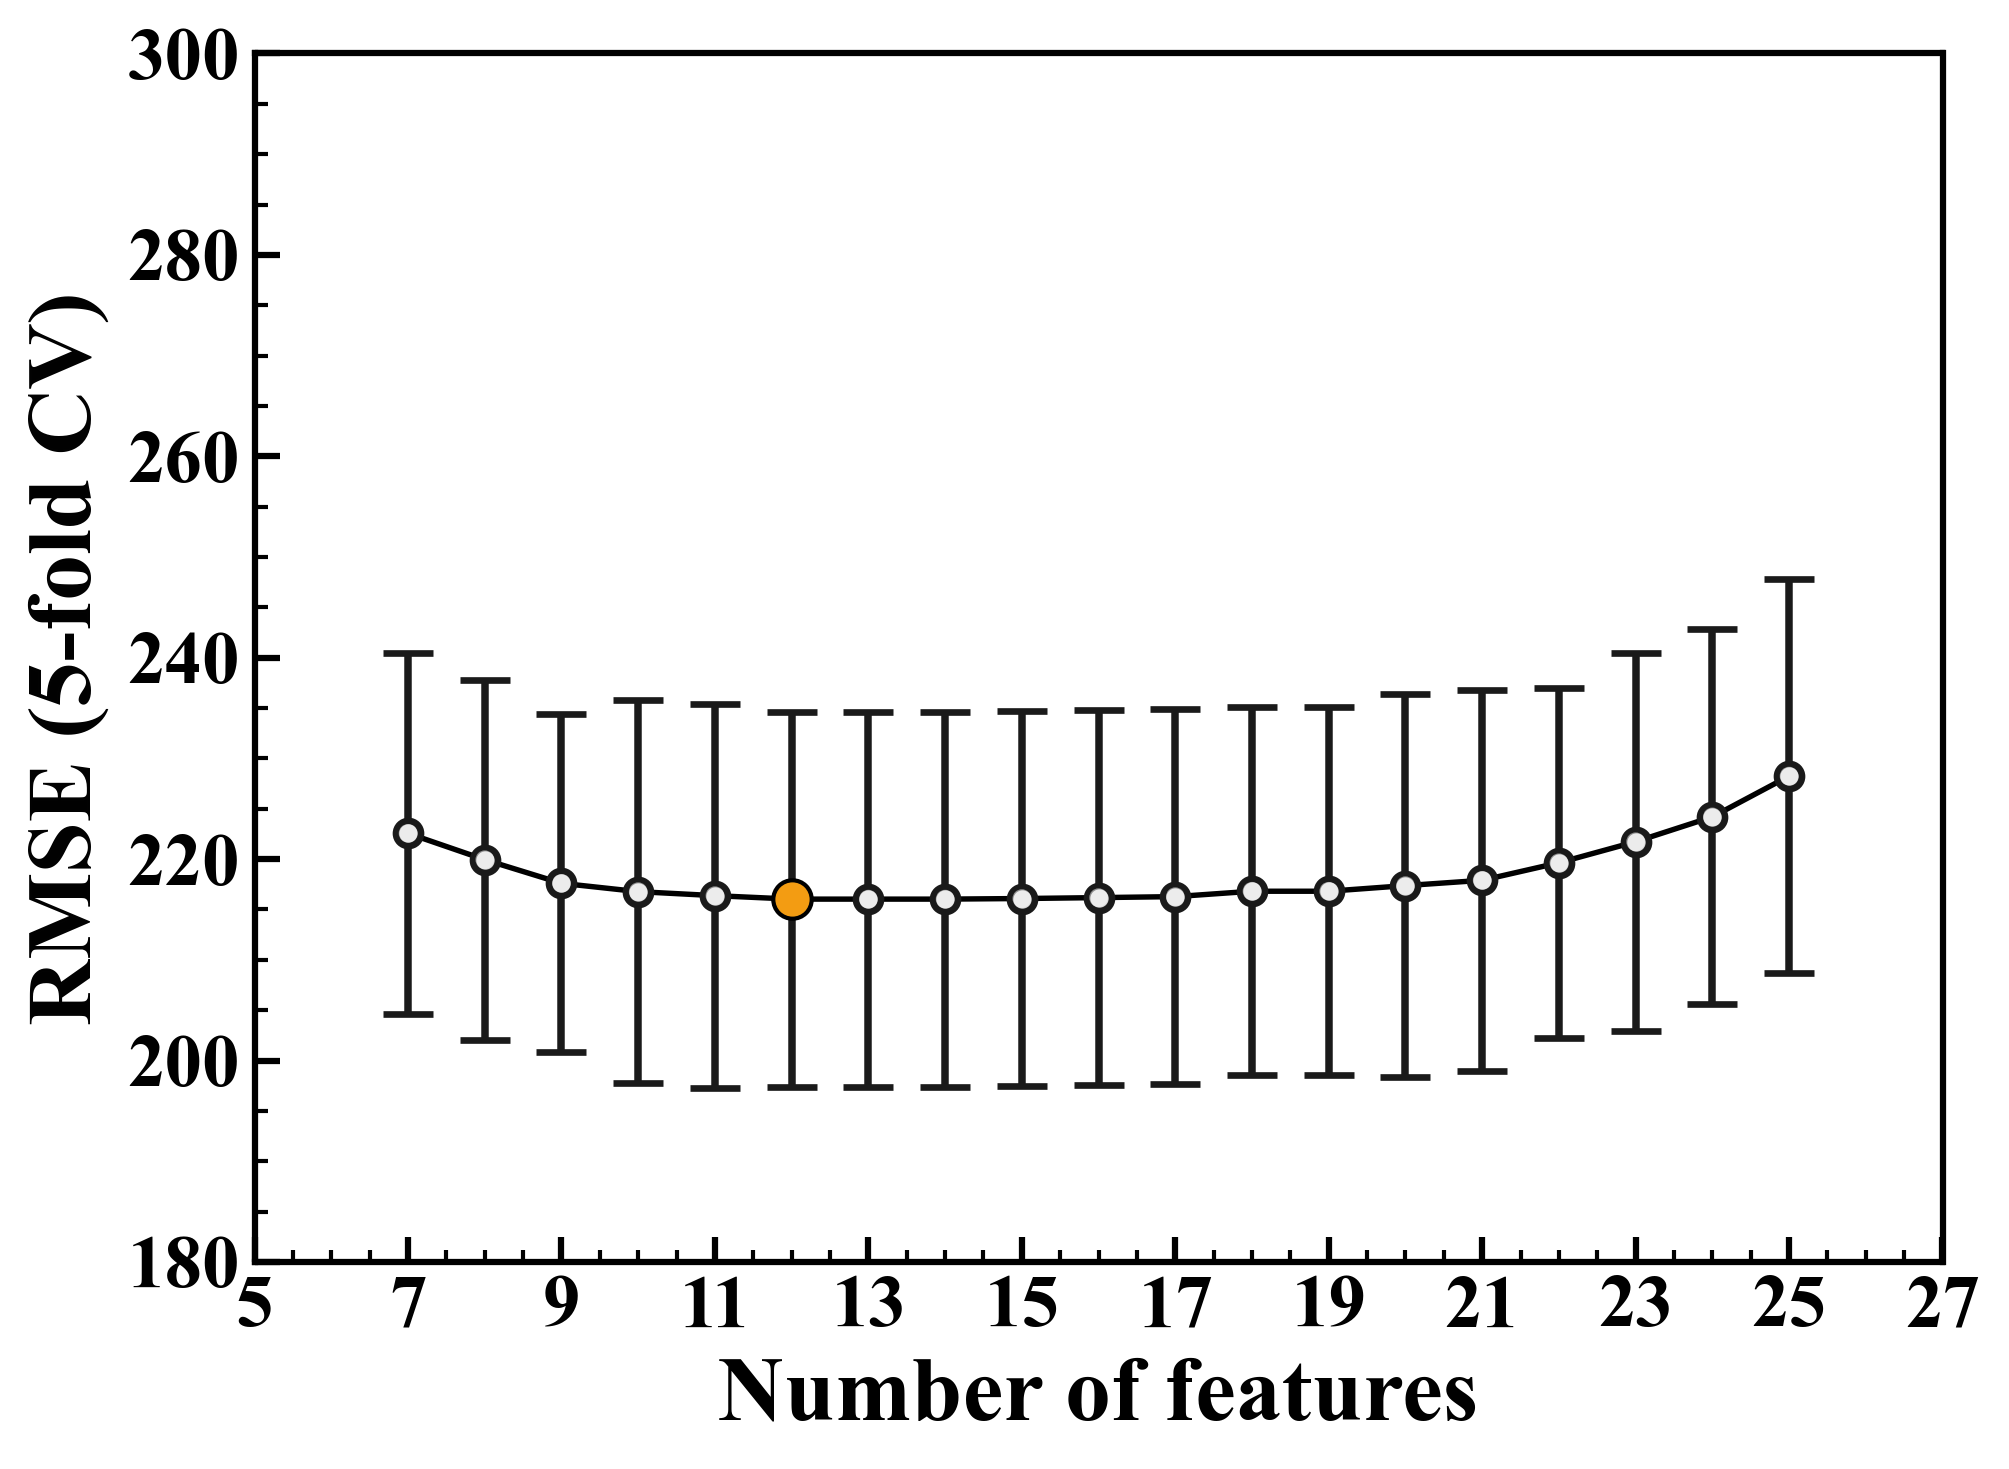

In [ ]:
x = df_ffs_xgb["Total Features"].to_numpy()
y = df_ffs_xgb["RMSE Mean"].to_numpy()
yerr = df_ffs_xgb["RMSE Std"].to_numpy()/2

i_best = np.argmin(y)
x_best, y_best = x[i_best], y[i_best]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(6.8, 5.0), dpi=300)
ax.errorbar(
    x, y, yerr=yerr,
    fmt='o',
    color='#1a1a1a',           
    ecolor='#1a1a1a',          
    elinewidth=1.8,
    capsize=6, capthick=1.8,    
    mfc='#d9d9d9',              
    mec='#1a1a1a',         
    ms=6, mew=1.6,
    zorder=2
)
ax.scatter(
    x, y, s=20, c='white', alpha=0.5,
    edgecolors='none', zorder=3
)
ax.plot(x, y, '-o', color='black', lw=1.3, markersize=4.5, zorder=1)
ax.scatter([x_best], [y_best], s=85, c='#f39c12', edgecolors='k', zorder=3)
ax.set_xlim(5, 27)
ax.set_ylim(180, 300)

ax.set_xticks(np.arange(5, 28, 2))  
ax.minorticks_on()                  
ax.tick_params(which='major', direction='in', length=6, width=1.5, labelsize=18)
ax.tick_params(which='minor', direction='in', length=3, width=1.0)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.set_xlabel('Number of features', fontsize=22, fontweight='bold')
ax.set_ylabel('RMSE (5-fold CV)', fontsize=22, fontweight='bold')

for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight('bold')
ax.grid(False)
plt.tight_layout()
plt.show()

In [17]:
df_ffs_rf = pd.read_excel("特征选择(图三)_0819.xlsx", sheet_name="RF特征正向筛选")

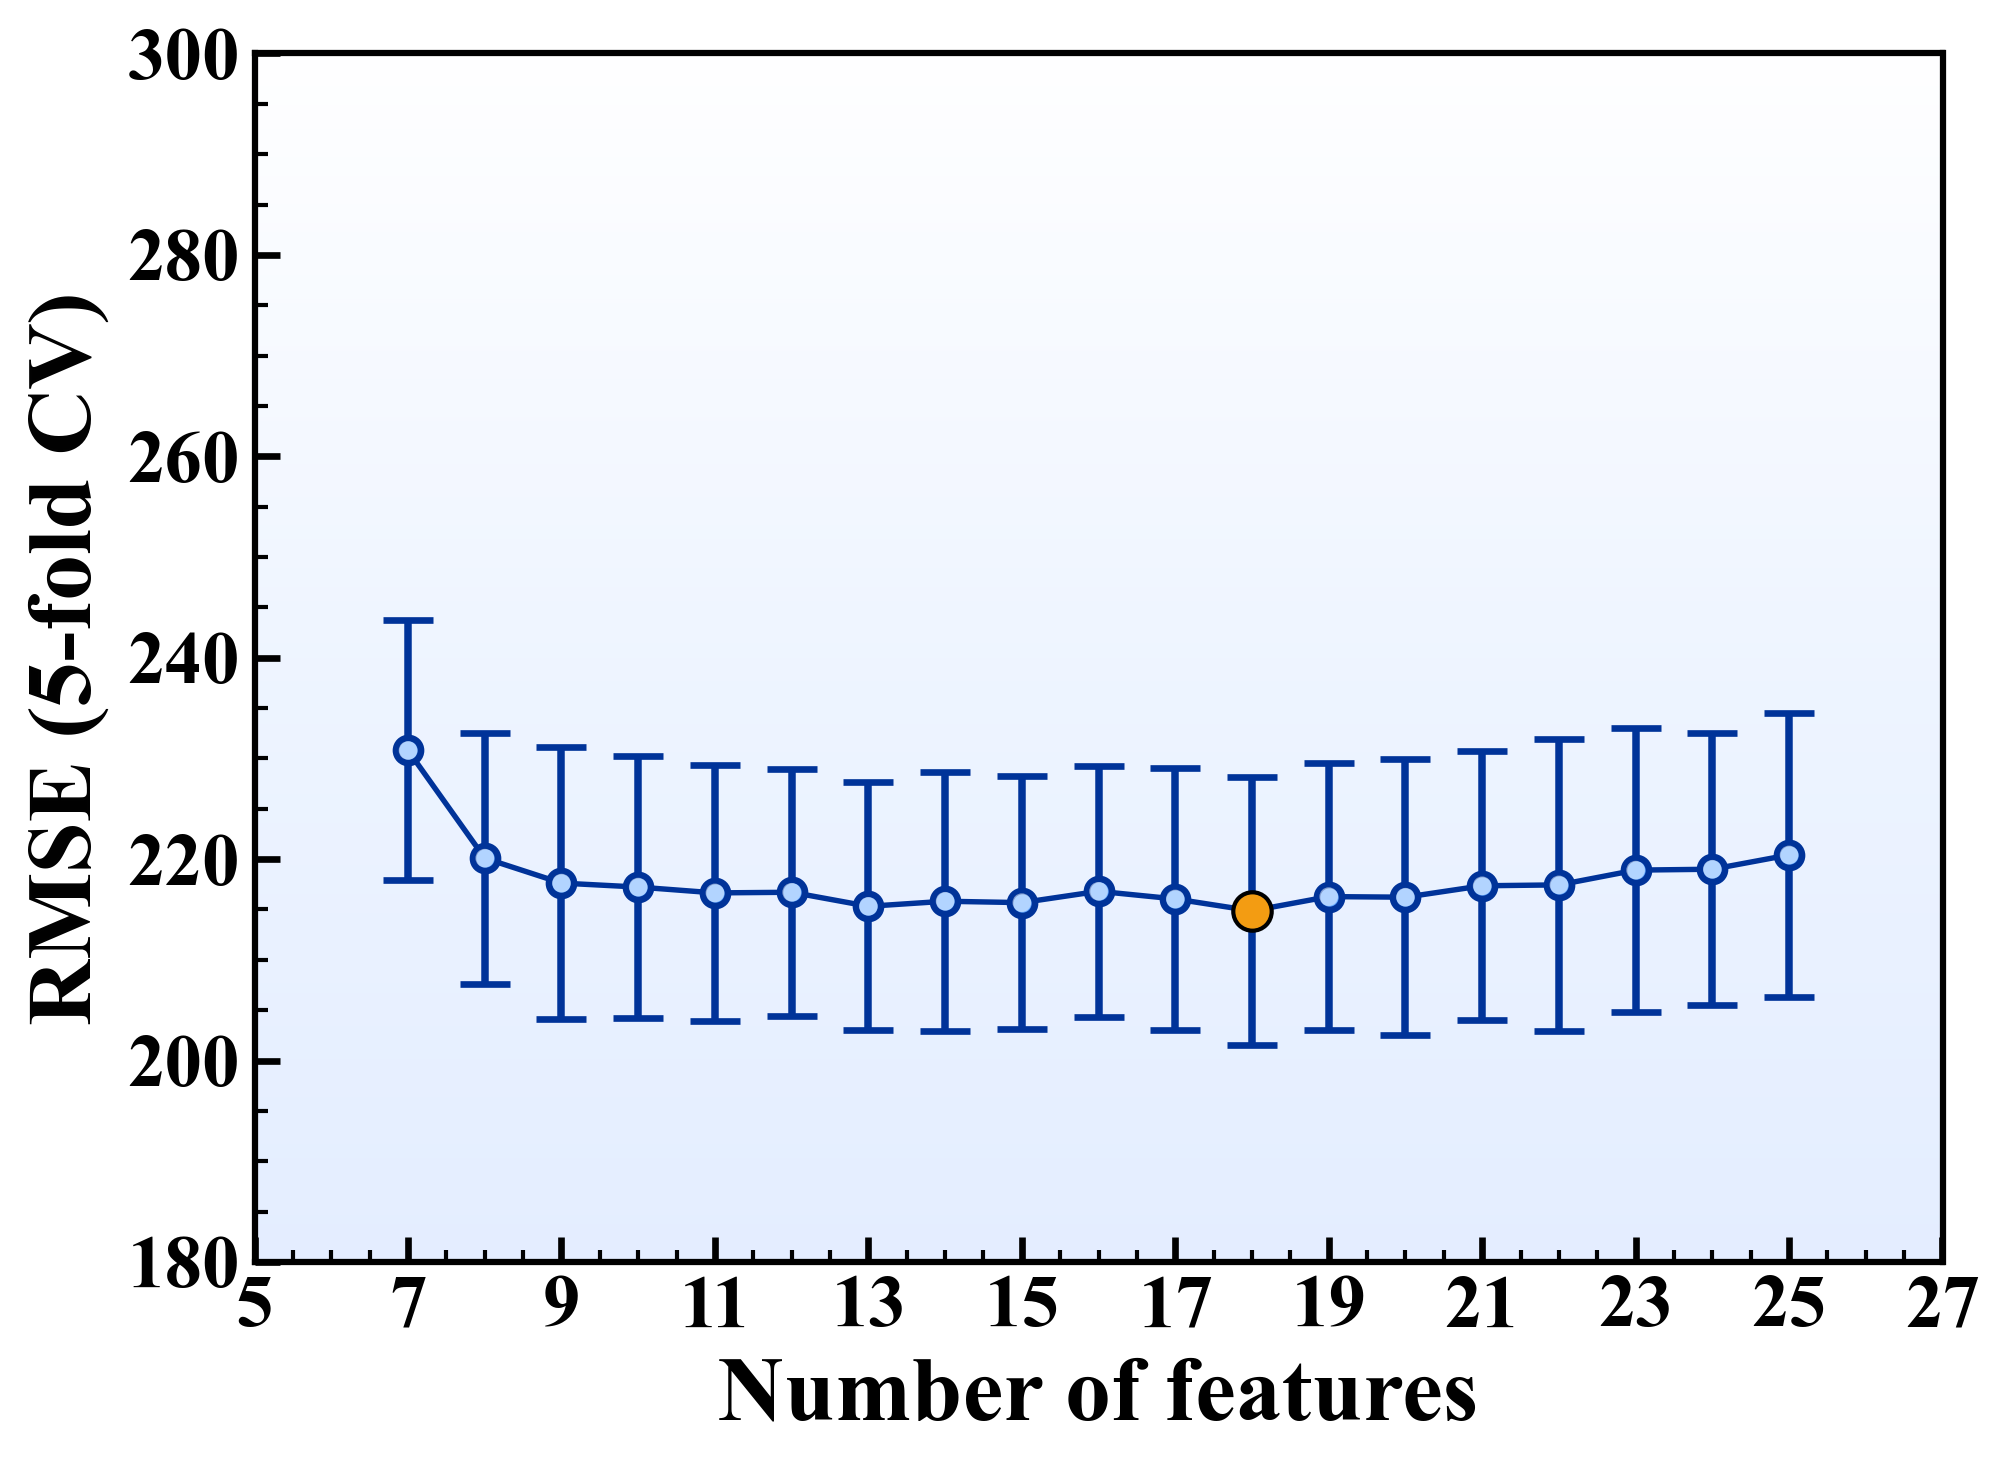

In [ ]:
x = df_ffs_rf["Total Features"].to_numpy()
y = df_ffs_rf["RMSE Mean"].to_numpy()     
yerr = df_ffs_rf["RMSE Std"].to_numpy() / 2

i_best = np.argmin(y)
x_best, y_best = x[i_best], y[i_best]

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(6.8, 5.0), dpi=300)

gradient = np.linspace(1, 0, 256)
gradient = np.vstack((gradient, gradient)).T
cmap = LinearSegmentedColormap.from_list(
    "white_blue",
    ["#ffffff", "#d6e6ff", "#bcd4ff"]
)
ax.imshow(
    gradient, extent=[5, 27, 180, 300], aspect='auto',
    origin='lower', cmap=cmap, alpha=0.4, zorder=0   
)

ax.errorbar(
    x, y, yerr=yerr,
    fmt='o',
    color='#003399',            
    ecolor='#003399',           
    elinewidth=1.8,
    capsize=6, capthick=1.8,    
    mfc='#66aaff',              
    mec='#003399',              
    ms=6, mew=1.6,
    zorder=2
)
ax.scatter(
    x, y, s=20, c='white', alpha=0.5,
    edgecolors='none', zorder=3
)
ax.plot(x, y, '-o', color='#003399', lw=1.3, markersize=4.5, zorder=1)
ax.scatter([x_best], [y_best], s=85, c='#f39c12', edgecolors='k', zorder=3)
ax.set_xlim(5, 27)
ax.set_ylim(180, 300)
ax.set_xticks(np.arange(5, 28, 2))
ax.minorticks_on()
ax.tick_params(which='major', direction='in', length=6, width=1.6, labelsize=18)
ax.tick_params(which='minor', direction='in', length=3, width=1.0)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight('bold')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

ax.set_xlabel('Number of features', fontsize=22, fontweight='bold')
ax.set_ylabel('RMSE (5-fold CV)', fontsize=22, fontweight='bold')
ax.grid(False)
plt.tight_layout()
plt.show()


In [32]:
df_ffs_svr  = pd.read_excel("特征选择(图三)_0819.xlsx", sheet_name="SVR特征正向筛选")

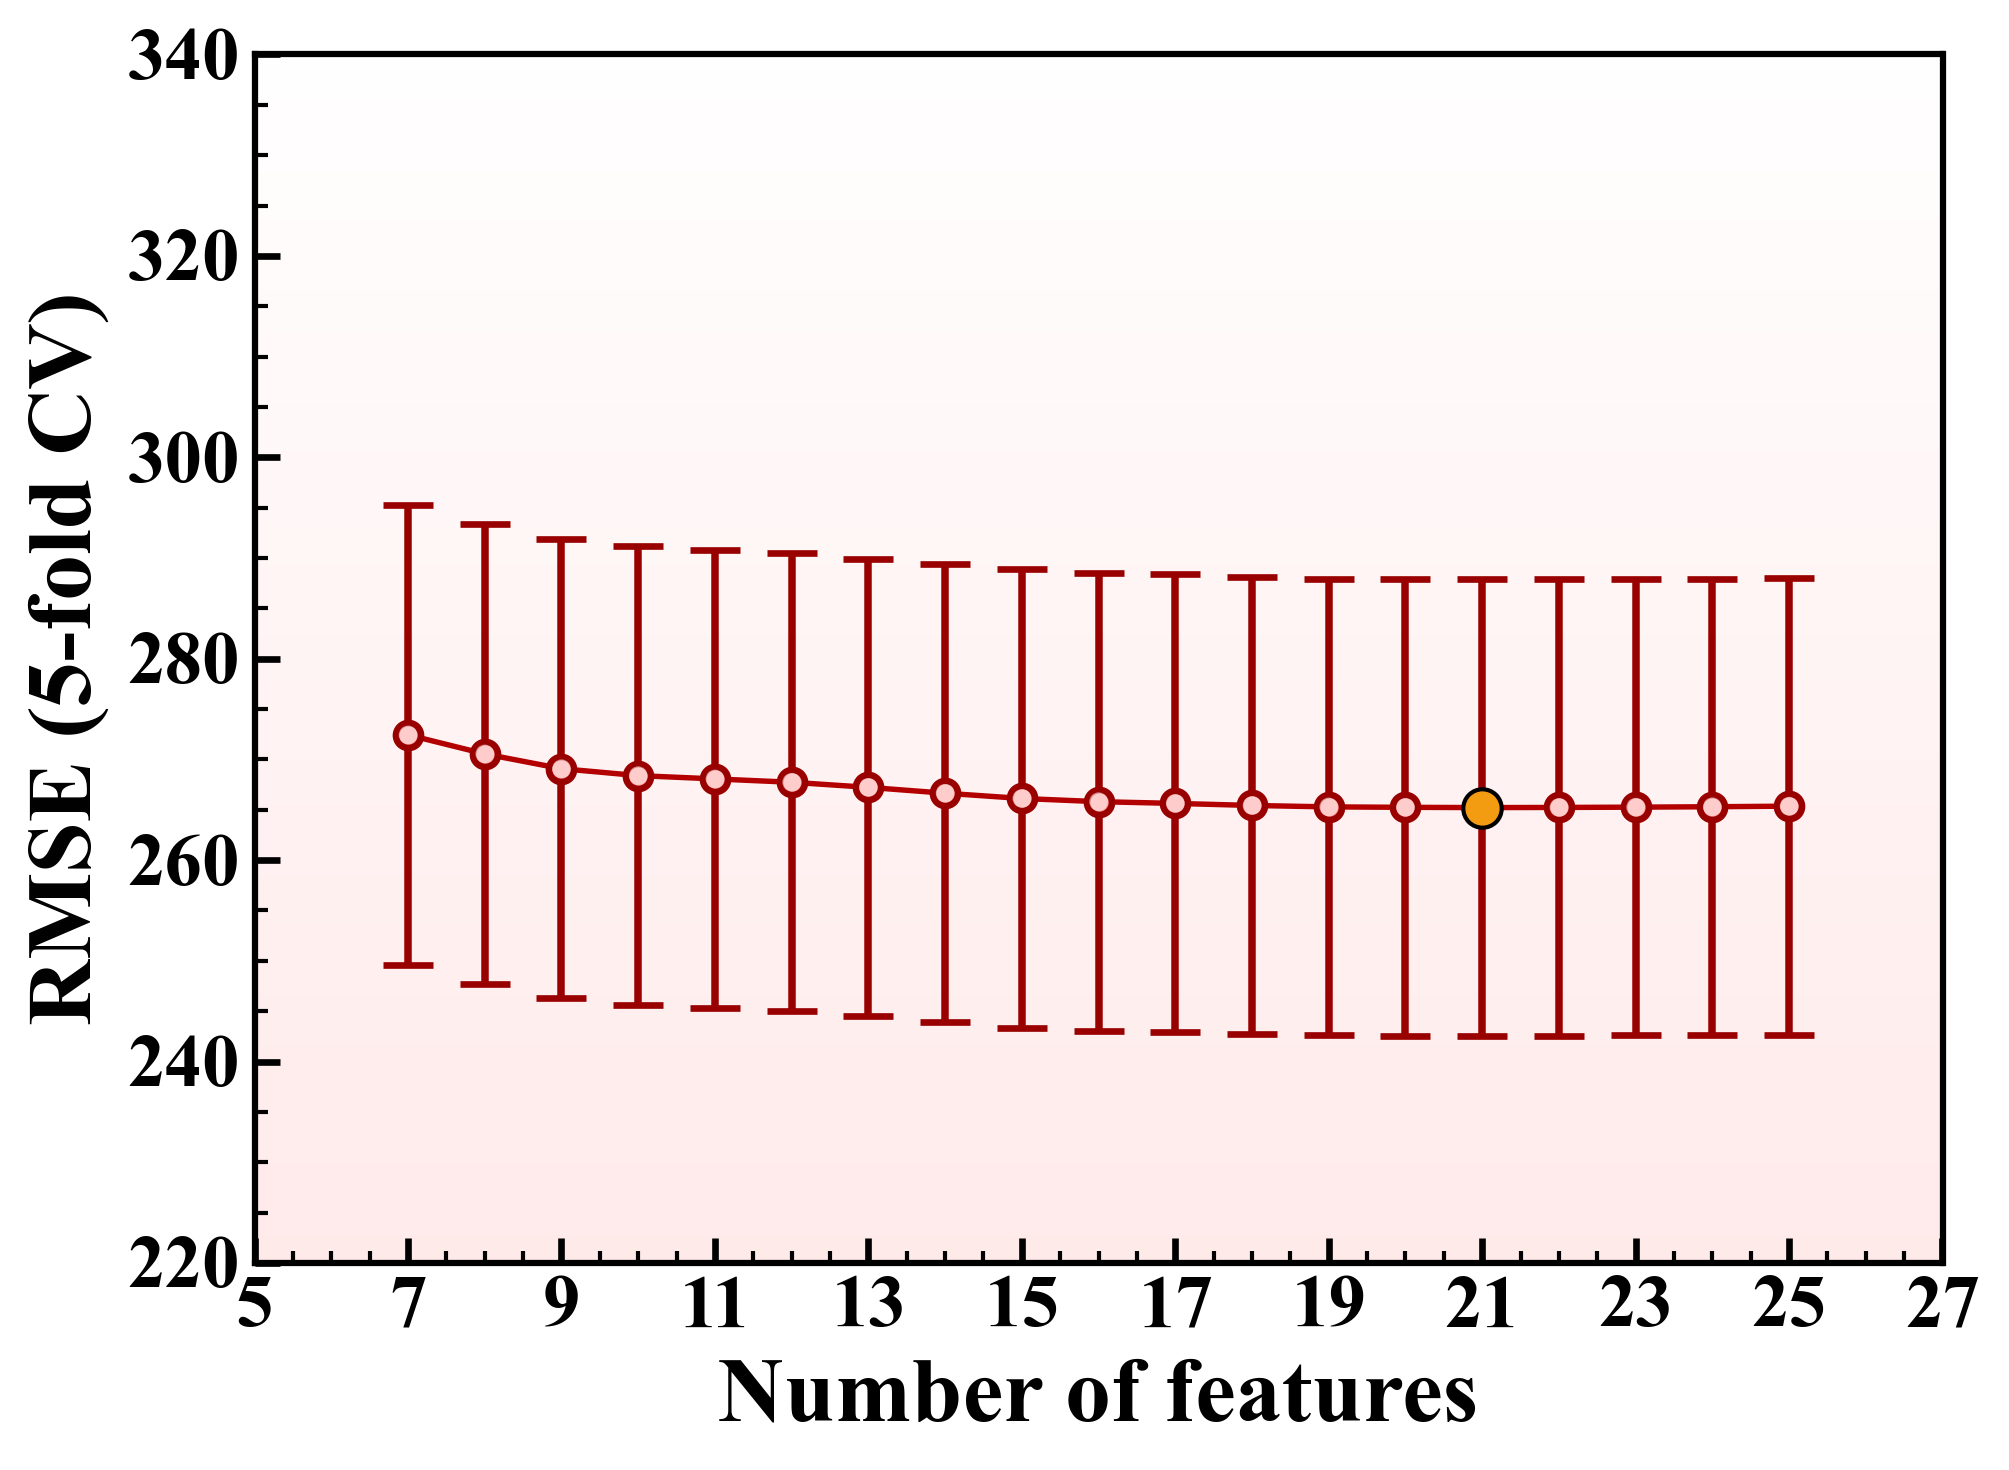

In [ ]:
x = df_ffs_svr["Total Features"].to_numpy()
y = df_ffs_svr["RMSE Mean"].to_numpy() 
yerr = df_ffs_svr["RMSE Std"].to_numpy() / 2
i_best = np.argmin(y)
x_best, y_best = x[i_best], y[i_best]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(6.8, 5.0), dpi=300)
gradient = np.linspace(1, 0, 256)
gradient = np.vstack((gradient, gradient)).T
cmap = LinearSegmentedColormap.from_list(
    "white_red",
    ["#ffffff", "#ffe5e5", "#ffcccc"]   
)
ax.imshow(
    gradient, extent=[5, 27, 220, 340], aspect='auto',
    origin='lower', cmap=cmap, alpha=0.4, zorder=0
)
ax.errorbar(
    x, y, yerr=yerr,
    fmt='o',
    color='#990000',           
    ecolor='#990000',           
    elinewidth=1.8,
    capsize=6, capthick=1.8,    
    mfc='#ff9999',              
    mec='#990000',              
    ms=6, mew=1.6,
    zorder=2
)
ax.scatter(
    x, y, s=20, c='white', alpha=0.5,
    edgecolors='none', zorder=3
)
ax.plot(
    x, y, '-o',
    color='#b30000', lw=1.3, markersize=4.5,
    zorder=1
)
ax.scatter([x_best], [y_best], s=85, c='#f39c12', edgecolors='k', zorder=3)
ax.set_xlim(5, 27)
ax.set_ylim(220, 340)
ax.set_xticks(np.arange(5, 28, 2))
ax.minorticks_on()
ax.tick_params(which='major', direction='in', length=6, width=1.6, labelsize=18)
ax.tick_params(which='minor', direction='in', length=3, width=1.0)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight('bold')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.set_xlabel('Number of features', fontsize=22, fontweight='bold')
ax.set_ylabel('RMSE (5-fold CV)', fontsize=22, fontweight='bold')
ax.grid(False)
plt.tight_layout()
plt.show()
# plt.savefig('ffs_xgb_gradient_blue.png', dpi=600, bbox_inches='tight')


In [42]:
df_ffs_mlp  = pd.read_excel("特征选择(图三)_0819.xlsx", sheet_name="RobustNN特征正向筛选")

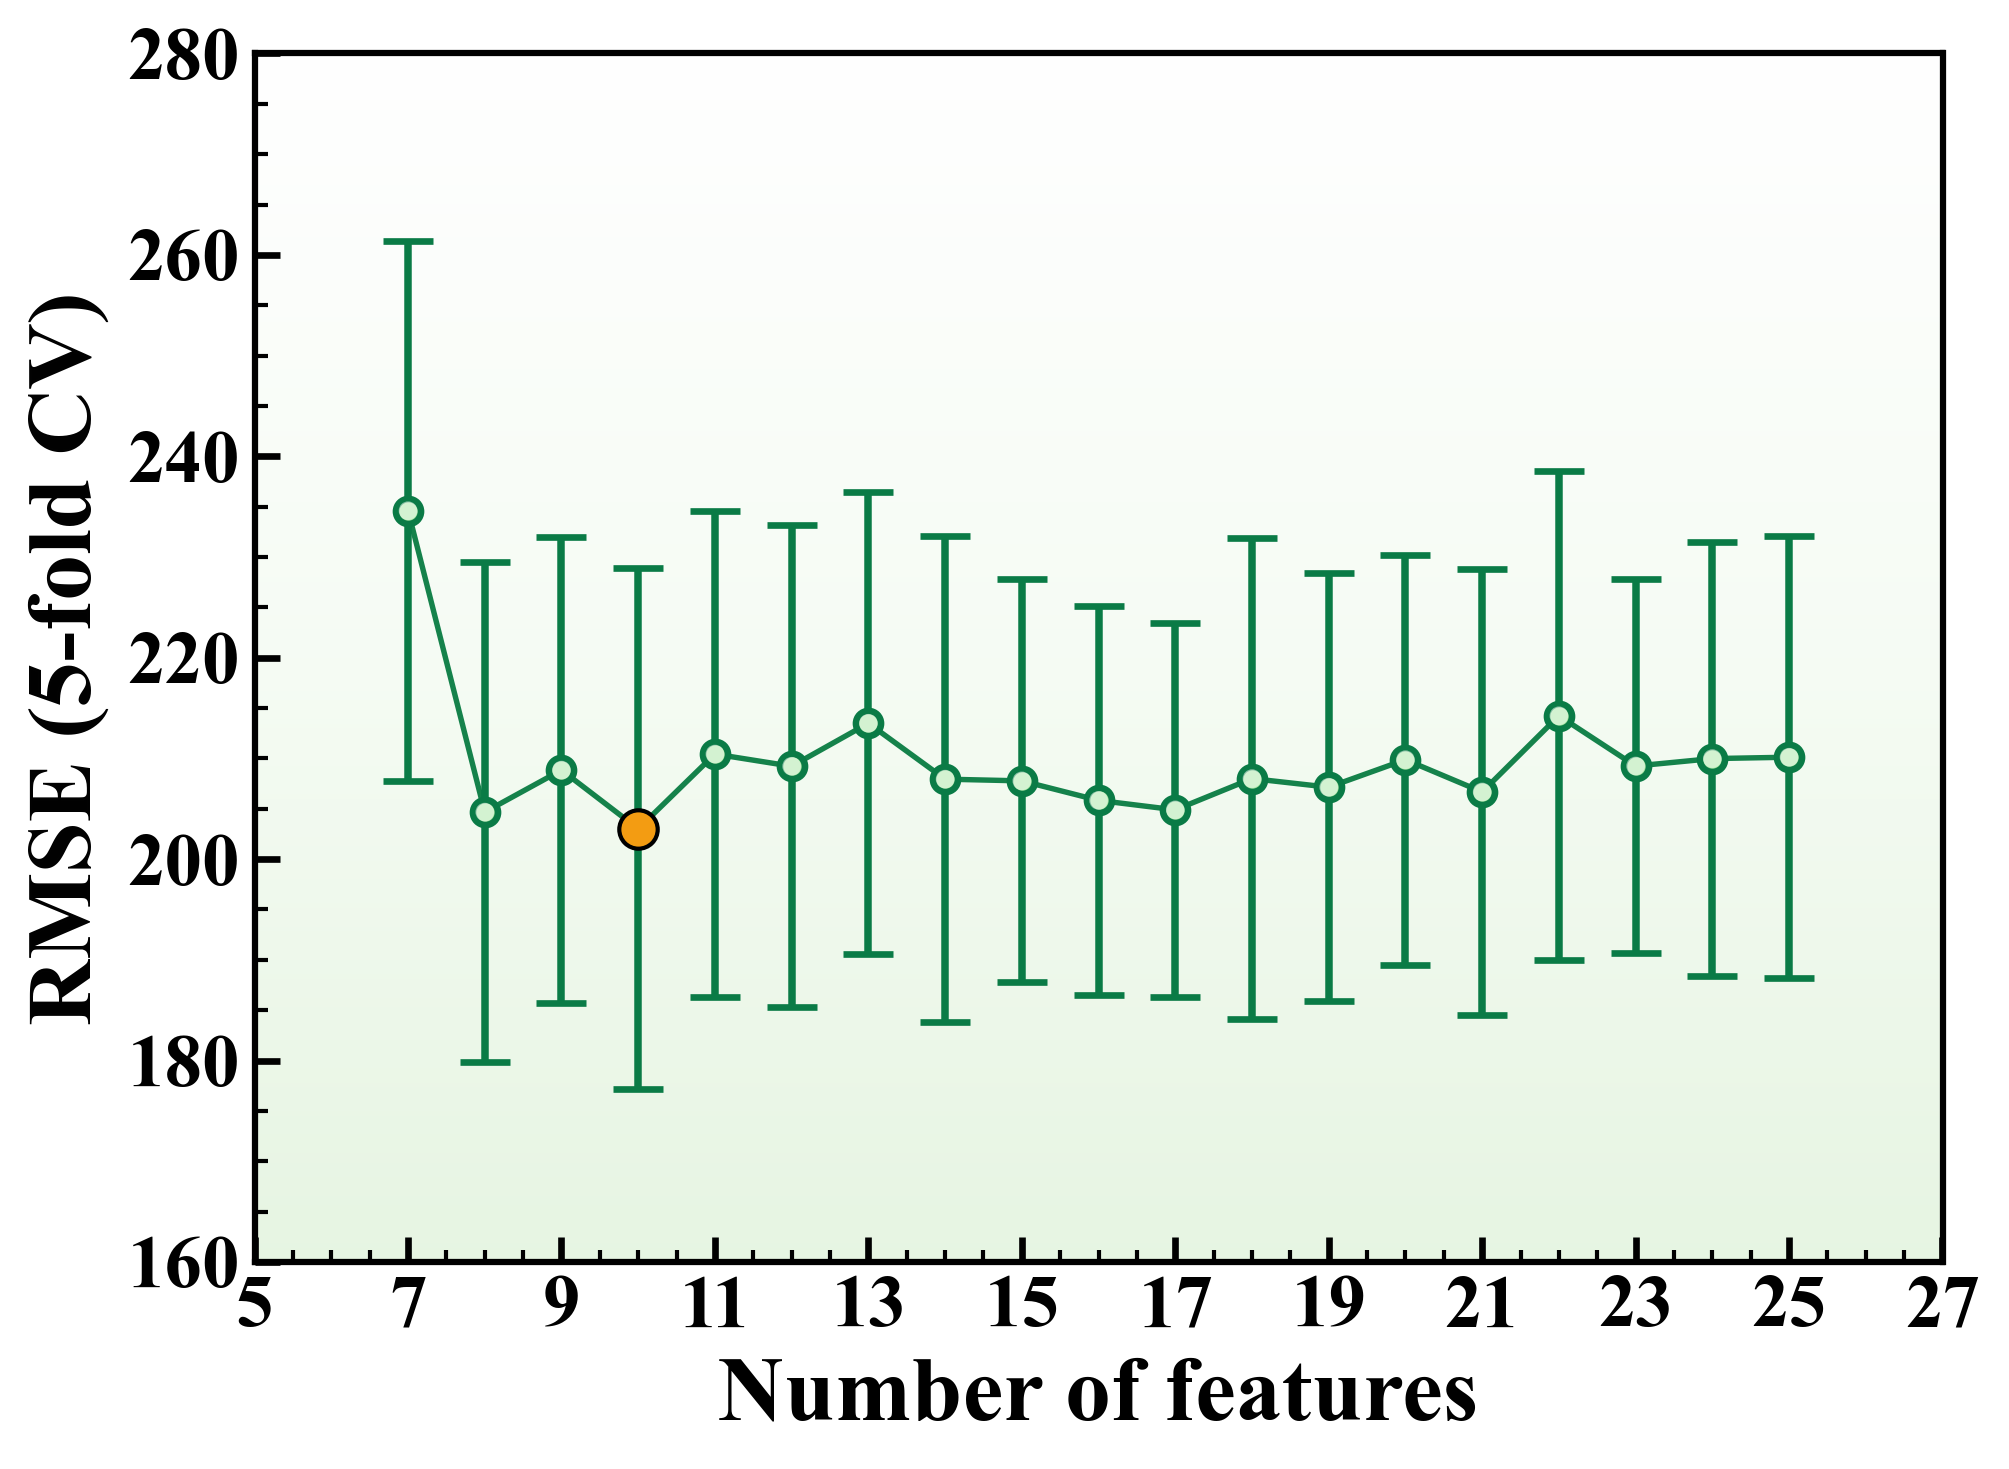

In [ ]:
x = df_ffs_mlp["Total Features"].to_numpy()
y = df_ffs_mlp["RMSE Mean"].to_numpy()    
yerr = df_ffs_mlp["RMSE Std"].to_numpy() / 2

i_best = np.argmin(y)
x_best, y_best = x[i_best], y[i_best]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(6.8, 5.0), dpi=300)
gradient = np.linspace(1, 0, 256)
gradient = np.vstack((gradient, gradient)).T
cmap = LinearSegmentedColormap.from_list(
    "white_green",
    ["#ffffff", "#e8f7e4", "#c2e6b8"] 
)
ax.imshow(
    gradient, extent=[5, 27, 160, 280], aspect='auto',
    origin='lower', cmap=cmap, alpha=0.4, zorder=0
)
ax.errorbar(
    x, y, yerr=yerr,
    fmt='o',
    color='#0a7b46',            
    ecolor='#0a7b46',       
    elinewidth=1.8,
    capsize=6, capthick=1.8,    
    mfc='#a8e6a3',              
    mec='#0a7b46',            
    ms=6, mew=1.6,
    zorder=2
)
ax.scatter(
    x, y, s=20, c='white', alpha=0.5,
    edgecolors='none', zorder=3
)
ax.plot(
    x, y, '-o',
    color='#15824b', lw=1.3, markersize=4.5,
    zorder=1
)
ax.scatter([x_best], [y_best], s=85, c='#f39c12', edgecolors='k', zorder=3)
ax.set_xlim(5, 27)
ax.set_ylim(160, 280)
ax.set_xticks(np.arange(5, 28, 2))
ax.minorticks_on()
ax.tick_params(which='major', direction='in', length=6, width=1.6, labelsize=18)
ax.tick_params(which='minor', direction='in', length=3, width=1.0)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight('bold')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.set_xlabel('Number of features', fontsize=22, fontweight='bold')
ax.set_ylabel('RMSE (5-fold CV)', fontsize=22, fontweight='bold')
ax.grid(False)
plt.tight_layout()
plt.show()
